# Regularization 

What regularization is
Regularization is a way to stop models from overfitting by penalizing complexity. Instead of letting coefficients grow freely to fit noise, the model is forced to keep them small or discard some entirely.

Why it’s needed
	•	Polynomial features and interactions explode the number of inputs.
	•	Plain linear regression has no built-in brake on complexity.
	•	Result: very low train error, much worse test error → overfitting.

Core idea

Allow the model to fit the data, but charge a “penalty” for being too complex.

⸻

The three models compared

1. Linear Regression (no regularization)
	•	Uses all features fully.
	•	Large coefficients.
	•	Big train–test gap → clear overfitting.
	•	No tuning knob to control complexity.

2. Ridge Regression (L2)
	•	Shrinks all coefficients toward zero.
	•	No coefficient is removed entirely.
	•	Controlled by alpha:
	•	Higher alpha → simpler, more stable model.
	•	Usually first choice in practice.
	•	Best when many features matter a little.

3. Lasso Regression (L1)
	•	Shrinks coefficients and sets some exactly to zero.
	•	Acts as automatic feature selection.
	•	Also controlled by alpha:
	•	Too high → underfitting.
	•	Too low → behaves like plain linear regression.
	•	Best when interpretability matters or many features are irrelevant.

⸻

Key observations from the notebook
	•	Regularized models drastically reduce the train–test gap.
	•	Ridge improves generalization while keeping all features.
	•	Lasso trades some accuracy for sparsity and clarity.
	•	Alpha tuning controls the bias–variance tradeoff.
	•	More regularization → smaller coefficients → better stability.

⸻

Practical rule of thumb
	•	Start with Ridge
	•	Use Lasso if you want fewer features and clearer interpretation
	•	Try ElasticNet if you want both shrinkage and sparsity

When training and evaluating a model, you will often have to deal with the problem of over- or underfitting. A simple way to prevent overfitting of a polynomial model is to reduce the number and degrees of polynomials. The linear regression model implemented in Scikit-Learn offers no further hyperparameter to constrain the complexity of the model. Fortunately, Scikit-Learn offers two other linear models: `Ridge Regression` and `Lasso Regression`. Both models can be used to reduce model complexity and prevent overfitting which can occur with simple linear regression.


In this notebook you will learn:
* why regularization is used
* how to apply ridge regression
* how to apply lasso regression
* how ridge and lasso regularization constrain the parameters/coefficients of the model slightly differently
* which hyperparameter for ridge and lasso regression can be tuned to influence model complexity

## Data



We will use the **Wine Quality Dataset** to show how ridge and lasso regression constrain the model complexity. Our dataset has 11 variables to predict the wine *quality*. 
For the purpose of this exercise we will also expand the dataset by generating interaction features. This means we will use not only the original features but also all products of feature pairs. 

The variables are (based on physiochemical tests): 

1 - fixed acidity

2 - volatile acidity

3 - citric acid

4 - residual sugar

5 - chlorides

6 - free sulfur dioxide

7 - total sulfur dioxide

8 - density

9 - pH

10 - sulphates

11 - alcohol

Output variable (based on sensory data):

12 - quality (score between 0 and 10)


## Imports and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Define random seed
RSEED = 0

# define figure size
plt.rcParams['figure.figsize'] = (10, 7)

In [2]:
df = pd.read_csv('data/winequality-white.csv',sep=";")
df.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


All our features are numeric, and there are no missing values. So, in order to understand how different regularization methods work, we can skip data cleaning for now.

In [4]:
# define features and target
features = df.columns.tolist()
features.remove('quality')
X = df[features]
y = df['quality']

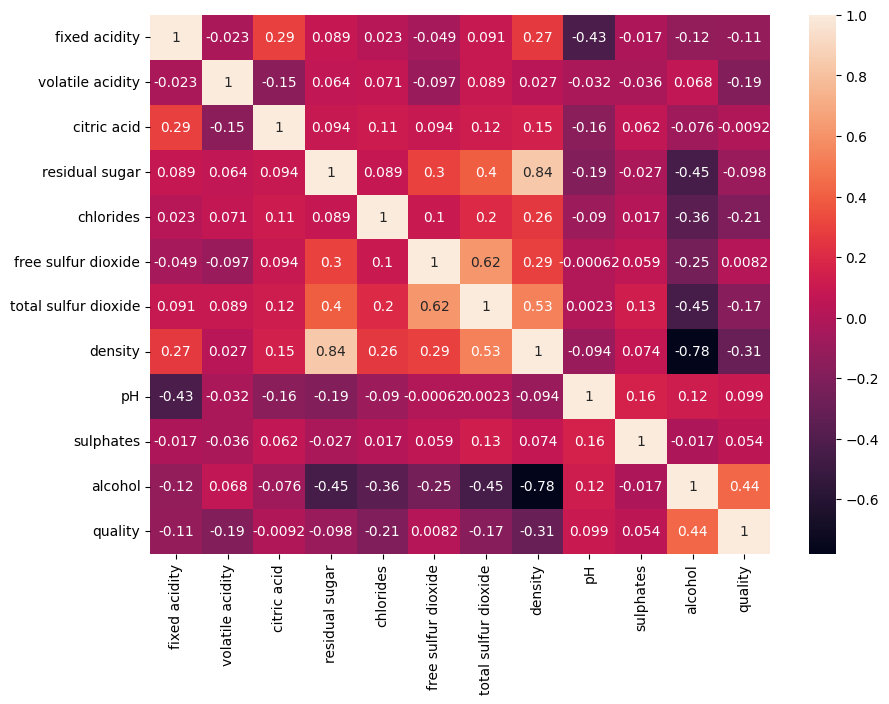

In [5]:
#correlation plot
ax = sns.heatmap(df.corr(), annot=True)

## Feature Engineering


We will create interaction terms (= feature combinations. For example X1*X2) of all the variables that exist in the dataset.
So, if we have three features (X1, X2, X3) and we want to create all interaction features of degree 2 (combinations of two only!), then we get in total 6 features. The three starting features plus all combinations of 2 feature: (X1, X2, X3, X1\*X2, X1\*X3, X2\*X3). 
If you want to understand all feature engineering possibilities of the `PolynomialFeatures` method, [checkout the documentation of scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).

In [6]:
# generate interaction features
poly = PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)
X_poly = poly.fit_transform(X)


To calculate how many interaction terms only exist for our 11 features (n) and degree of 2 (k) (combinations of 2 features only), you can use this formula to calculate [combinations](https://en.wikipedia.org/wiki/Combination): 

${\displaystyle {\binom {n}{k}}={\frac {n(n-1)\dotsb (n-k+1)}{k(k-1)\dotsb 1}}=  {\frac {n!}{k!(n-k)!}}}$

In [7]:
# In our case with 11 features, we end up with 66 features (11 features + 55 combinations)
poly.n_output_features_

66

## Train-test-split


Before we train our models we will split the data in order to have a test dataset for the evaluation of our models.

In [8]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=RSEED, test_size=0.4)


In [9]:
# Let's check the shape of our dataframes
print("Training samples: ", X_train.shape[0],"  Nr. of Features: ", X_train.shape[1])
print("Training lables: ", y_train.shape[0])
print( "----"*12)
print("Test samples: ",X_test.shape[0],"  Nr. of Features: ",X_test.shape[1])
print("Test lables: ",y_test.shape[0])

Training samples:  2938   Nr. of Features:  66
Training lables:  2938
------------------------------------------------
Test samples:  1960   Nr. of Features:  66
Test lables:  1960


## Linear Regression

We will start by training a linear regression model. 
We can use sklearns `LinearRegression` class to train a model which contains all of our available features.

For each of our model we will evaluate the performance with looking at the RMSE (root mean squared error).



In [10]:
from sklearn.linear_model import LinearRegression

# initialize and train model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# predict on test-set
y_pred_lin = lin_reg.predict(X_test)
y_pred_train = lin_reg.predict(X_train)

# RMSE on train and test set
print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 3))
print("Test RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_lin)), 3))

Train RMSE: 0.693
Test RMSE: 0.879


We can see that our model performs well on the training data but the RMSE on the test set is much worse. This discrepancy between the performance on the trainings and test set is a clear sign of overfitting. Since `LinearRegression` has no hyperparameters for constraining model complexity we will need to use another model. 

For comparison sake, we will also have a look at the value of the highest coefficient and how many coefficients are zero.

In [13]:
def coeff_info(model):
    coeff_used = np.sum(model.coef_!=0)
    print('The model is using', coeff_used, 'out of 66 features.')
    print( "The highest coefficient has a value of:", max(model.coef_.round(3)))

In [14]:
coeff_info(lin_reg)

The model is using 66 out of 66 features.
The highest coefficient has a value of: 5941.648


## Ridge Regression (l2 regularization)



A commonly used alternative to the "normal" linear regression model is `Ridge` regression. It is also a linear model that uses basically the same formula that is used for ordinary least squares. However, our ridge regression model will also try to keep the magnitude of coefficients to be as small as possible. In other words, all entries of *w* should be close to zero. We can also say, each feature should have as little effect on the outcome as possible while still predicting well. 

If you have a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) you can see that this model has a hyperparameter called *alpha* which can be adjusted. Increasing alpha forces coefficients to move more toward zero, which decreases training set performance but might help generalization. 

Let's see how ridge regression with different alpha values performs on our dataset:

In [15]:
from sklearn.linear_model import Ridge

In [16]:
# initialize and train model with (default value) alpha = 10
ridge_10 = Ridge(alpha=10)
ridge_10.fit(X_train, y_train)

# predict on test-set
y_pred_ridge = ridge_10.predict(X_test)
y_pred_train = ridge_10.predict(X_train)

# RMSE of test set
print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 3))
print("Test  RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_ridge)), 3))

Train RMSE: 0.706
Test  RMSE: 0.778


In [17]:
coeff_info(ridge_10)

The model is using 66 out of 66 features.
The highest coefficient has a value of: 0.341


In [18]:
# initialize and train model with alpha = 1
ridge_1 = Ridge(alpha=1)
ridge_1.fit(X_train, y_train)

# predict on test-set
y_pred_ridge_1 = ridge_1.predict(X_test)
y_pred_train_1 = ridge_1.predict(X_train)

# RMSE of test set

print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred_train_1)), 3))
print("Test  RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_ridge_1)), 3))

Train RMSE: 0.703
Test  RMSE: 0.781


In [19]:
coeff_info(ridge_1)

The model is using 66 out of 66 features.
The highest coefficient has a value of: 0.743


In [20]:
# initialize and train model with alpha = 0.1
ridge_01 = Ridge(alpha=0.1)
ridge_01.fit(X_train, y_train)

# predict on test-set
y_pred_ridge_01 = ridge_01.predict(X_test)
y_pred_train_01 = ridge_01.predict(X_train)

# RMSE of test set
print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred_train_01)), 3))
print("Test  RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_ridge_01)), 3))

Train RMSE: 0.7
Test  RMSE: 0.792


In [21]:
coeff_info(ridge_01)

The model is using 66 out of 66 features.
The highest coefficient has a value of: 2.073


You can see that all three models perform clearly better compared to the linear regression model and the difference in the train and test score is considerably lower. Thus our models are not overfitting as much as the linear regression.  
In our case the  value of alpha = 10 provides the best results. The optimum setting of alpha depends on the particular dataset we are using.


We can also visualize the magnitude of our coefficients. 
On the x-axis the number of all our coefficients(we have 66 variables) are plotted as coefficient index (b1, b2, b3 etc.) and on the y-axis the values for these coefficients.


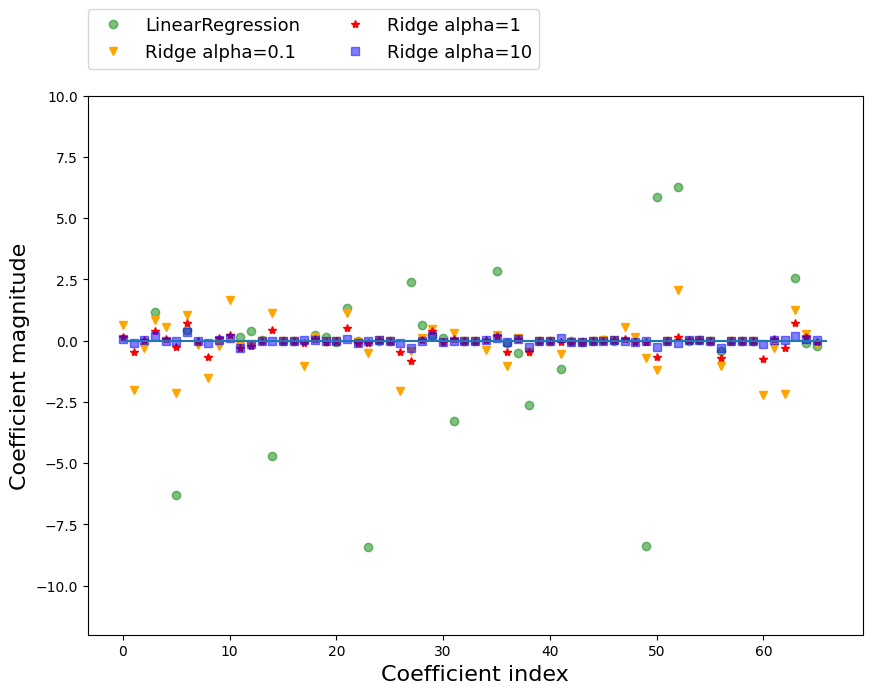

In [22]:
# plot of different coefficients
# linear regression without regularization
plt.plot(lin_reg.coef_, 'o', alpha=0.5, label="LinearRegression", color='green')
# ridge regression with lowest alpha value = regularization term
plt.plot(ridge_01.coef_, 'v', label="Ridge alpha=0.1", color='orange')
# ridge regression with middle alpha value = regularization term
plt.plot(ridge_1.coef_, '*', label="Ridge alpha=1", color='red')
# ridge regression with highest alpha value = regularization term
plt.plot(ridge_10.coef_, 's', alpha=0.5, label="Ridge alpha=10", color='blue')


plt.xlabel("Coefficient index", fontsize=16)
plt.ylabel("Coefficient magnitude", fontsize=16)
plt.hlines(0, 0, len(lin_reg.coef_))
plt.ylim(-12, 10)
plt.legend(fontsize=13, ncol=2, loc=(0, 1.05));

The plot nicely shows how the higher the alpha values get the closer the coefficients are to zero. 
The green dots representing the coefficients from our linear regression model without any regularization are sometimes so large that they are nearly outside our plot.

## Lasso Regression (l1 regularization)



An alternative to `Ridge` is `Lasso` regression. Similarly to ridge regression lasso restricts coefficients to be close to zero. It does so in a slightly different way so that when using lasso some coefficients become exactly zero. This means some features are entirely ignored by the model. It can be seen as an automatic feature selection which makes models often easier to interpret and can reveal the most important features.



A look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso) shows us that lasso has also a hyperparameter called *alpha* which can be adjusted. Lowering alpha allows us to fit a more complex model. If alpha is set too low, however, we end up getting a similar result as with linear regression since no regularization will take place.  

Let's try lasso regression with different alpha values:

In [23]:
from sklearn.linear_model import Lasso

In [24]:
# initialize and train model with (default value) alpha = 0.5
lasso_05 = Lasso(alpha=0.5, max_iter=int(10e5))
lasso_05.fit(X_train,y_train)

# predict on test-set
y_pred_lasso = lasso_05.predict(X_test)
y_pred_train_lasso = lasso_05.predict(X_train)

# RMSE of test set
print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred_train_lasso)), 3))
print("Test  RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_lasso)), 3))


Train RMSE: 0.741
Test  RMSE: 0.789


In [25]:
coeff_info(lasso_05)

The model is using 10 out of 66 features.
The highest coefficient has a value of: 0.002


In [26]:
# initialize and train model with alpha 0.05

lasso_005 = Lasso(alpha=0.05, max_iter=100000)
lasso_005.fit(X_train,y_train)

# predict on test-set
y_pred_lasso_005 = lasso_005.predict(X_test)
y_pred_train_lasso_005 = lasso_005.predict(X_train)

# RMSE of test set
print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred_train_lasso_005)), 3))
print("Test  RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_lasso_005)), 3))


Train RMSE: 0.724
Test  RMSE: 0.772


In [27]:
coeff_info(lasso_005)

The model is using 16 out of 66 features.
The highest coefficient has a value of: 0.067


In [28]:
# initialize and train model with alpha 0.005
lasso_0005 = Lasso(alpha=0.005, max_iter=100000)
lasso_0005.fit(X_train,y_train)

# predict on test-set
y_pred_lasso_0005 = lasso_0005.predict(X_test)
y_pred_train_lasso_0005 = lasso_0005.predict(X_train)

# RMSE of test set
print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred_train_lasso_0005)), 3))
print("Test  RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_lasso_0005)), 3))

Train RMSE: 0.713
Test  RMSE: 0.775


In [29]:
coeff_info(lasso_0005)

The model is using 29 out of 66 features.
The highest coefficient has a value of: 0.12


You can see that our lasso model with alpha = 0.5 performs rather bad and only uses 10 features. Lowering alpha to allow for a more complex model results in a better performance. The RMSE of our models with alpha = 0.05 and alpha = 0.005 are quite similar but there is still quite a difference in the number of features which are used. Since less features often makes it easier to interpret our model we will go for alpha = 0.05. 

We can also visualize the coefficients of our lasso models. 

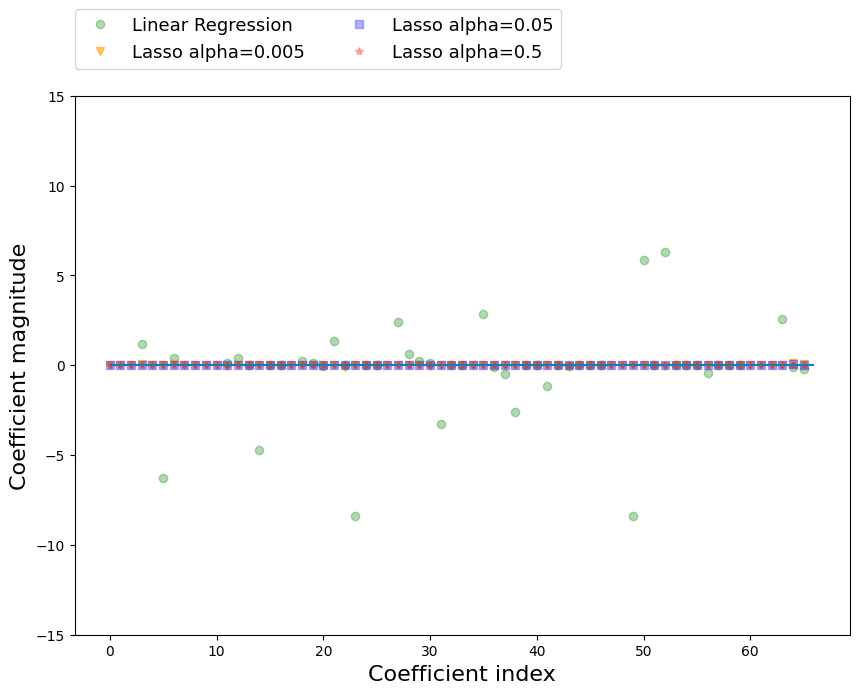

In [30]:
# plot of different coefficients
plt.plot(lin_reg.coef_, 'o', alpha=0.3, label="Linear Regression", color='green')
# lasso regression with lowest alpha value = regularization term
plt.plot(lasso_0005.coef_, 'v', alpha=0.6, label="Lasso alpha=0.005", color='orange')
# lasso regression with middle alpha value = regularization term
plt.plot(lasso_005.coef_, 's', alpha=0.3, label="Lasso alpha=0.05", color='blue')
# lasso regression with highest alpha value = regularization term
plt.plot(lasso_05.coef_, '*', alpha=0.3,label="Lasso alpha=0.5", color='red')

plt.xlabel("Coefficient index", fontsize=16)
plt.ylabel("Coefficient magnitude", fontsize=16)
plt.hlines(0, 0, len(lin_reg.coef_))
plt.ylim(-15, 15)
plt.legend(fontsize=13, ncol=2, loc=(0, 1.05));

To really see the differences in coefficient values for Lasso Regularization, we will zoom in a bit more. Remember, that most of the coefficients for linear regression will not be in the plotted y-range.

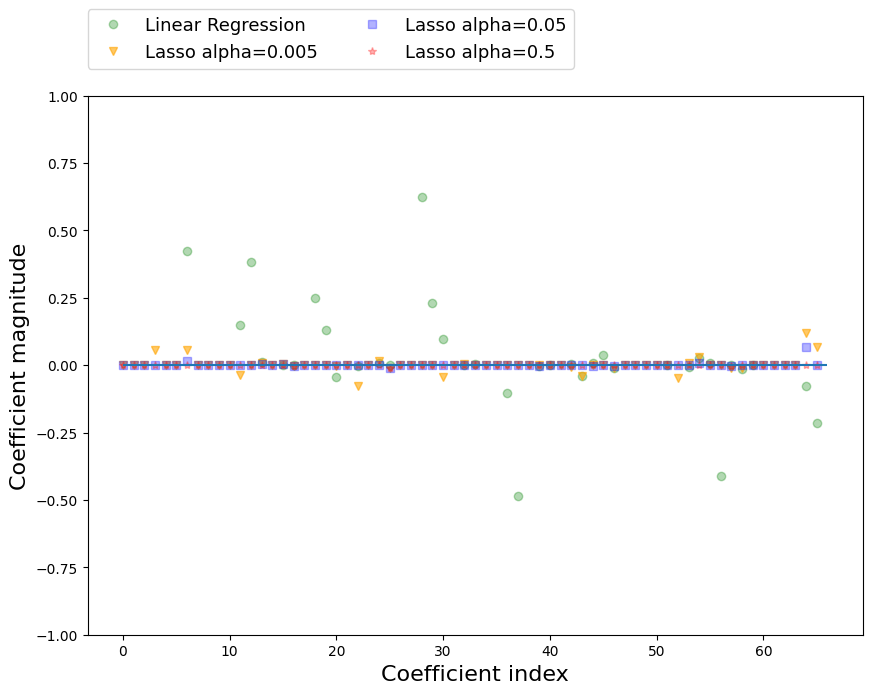

In [31]:
# plot of different coefficients
plt.plot(lin_reg.coef_, 'o', alpha=0.3, label="Linear Regression", color='green')
# lasso regression with lowest alpha value = regularization term
plt.plot(lasso_0005.coef_, 'v', alpha=0.6, label="Lasso alpha=0.005", color='orange')
# lasso regression with middle alpha value = regularization term
plt.plot(lasso_005.coef_, 's', alpha=0.3, label="Lasso alpha=0.05", color='blue')
# lasso regression with highest alpha value = regularization term
plt.plot(lasso_05.coef_, '*', alpha=0.3,label="Lasso alpha=0.5", color='red')

plt.xlabel("Coefficient index", fontsize=16)
plt.ylabel("Coefficient magnitude", fontsize=16)
plt.hlines(0, 0, len(lin_reg.coef_))
plt.ylim(-1, 1)
plt.legend(fontsize=13, ncol=2, loc=(0, 1.05));

For alpha = 0.5 we can see that most of the coefficients are actually zero and the others are also quite small. Even if the plot for our ridge regressions looked similar, the coefficients of the ridge models were close but never exactly zero. 

## Summary



Now you saw two different ways to prevent your linear regression model from overfitting. In practice, ridge regression is usually the first choice. However, if you have a large amount of features and want to improve the interpretability of your model it makes sense to go for lasso regression since it will eliminate some of your features. 

But there is also a third model implemented in scikit-learn: the [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elasticnet#sklearn.linear_model.ElasticNet) regression. This model combines the penalties of Lasso and Ridge. Often this combination works best.

Feel free to experiment with the `ElasticNet` regression model and compare the results to the other regularization methods. 

### Further Reading


The examples in this notebook can be found similarly in Andreas C. Müllers and Sarah Guidos book **Introduction to Machine Learning with Python**. If you need further explanations have a look at the chapter on supervised learning/linear regression. 

# Regularization — easy simple notes

## What it is
Regularization is a way to stop overfitting by making the model **pay a cost for being too “wiggly”**.
It does this by pushing coefficients to be **smaller** (or sometimes **zero**).

---

## Why you need it
- When you add polynomial/interaction features, you suddenly have **tons of inputs**.
- Plain linear regression will happily use them to **memorize** the training data.
- That looks great on train data, but performs worse on test data → **overfitting**.

---

## Core idea
> Fit the data, but don’t let the model get too complicated.

---

## The 3 models

### 1) Linear Regression (no regularization)
- No limits on coefficient size.
- Coefficients can get huge.
- Often overfits when there are many features.
- No “strength” dial to control complexity.

---

### 2) Ridge (L2)
- Makes **all** coefficients smaller.
- Keeps every feature (almost nothing becomes exactly zero).
- Has one main dial: **alpha**
  - Higher alpha = stronger shrink = simpler model
- Usually the default first thing to try.

---

### 3) Lasso (L1)
- Makes coefficients smaller **and can set some to exactly zero**.
- That means it can **drop features automatically**.
- Also controlled by **alpha**
  - Too high = model becomes too simple (underfits)
  - Too low = acts like normal linear regression
- Good when you want a simpler, easier-to-explain model.

---

## What alpha really controls
- **Higher alpha:** simpler model, more stable, less overfitting risk
- **Lower alpha:** more flexible model, higher overfitting risk

---

## What you saw in the notebook
- Linear regression overfit with interaction features (train good, test worse).
- Ridge reduced the train–test gap.
- Lasso reduced the gap AND removed some features (more interpretable).
- Ridge shrinks coefficients but rarely hits zero.
- Lasso can push coefficients to exactly zero.

---

## Quick rules
- Start with **Ridge**.
- Use **Lasso** if you want feature selection / simpler explanation.
- Try **ElasticNet** if you want “Ridge + Lasso” together.